In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xg
from sklearn.feature_selection import RFECV

import sqlite3
import pandas as pd

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
conn= sqlite3.connect("datacamp_python.db")

data = pd.read_csv("/kaggle/input/open-university-learning-analytics-dataset/assessments.csv")
data.to_sql(
            'assessments',            
            conn,                 
            if_exists='replace'
           )

courses_data = pd.read_csv("/kaggle/input/open-university-learning-analytics-dataset/courses.csv")
courses_data.to_sql('courses', conn, if_exists='replace', index=False)

student_info_data = pd.read_csv("/kaggle/input/open-university-learning-analytics-dataset/studentInfo.csv")
student_info_data.to_sql('student_info', conn, if_exists='replace', index=False)

student_registration_data = pd.read_csv("/kaggle/input/open-university-learning-analytics-dataset/studentRegistration.csv")
student_registration_data.to_sql('student_registration', conn, if_exists='replace', index=False)

vle_data = pd.read_csv("/kaggle/input/open-university-learning-analytics-dataset/vle.csv")
vle_data.to_sql('vle', conn, if_exists='replace', index=False)

student_vle_data = pd.read_csv("/kaggle/input/open-university-learning-analytics-dataset/studentVle.csv")
student_vle_data.to_sql('student_vle', conn, if_exists='replace', index=False)

student_assessment_data = pd.read_csv("/kaggle/input/open-university-learning-analytics-dataset/studentAssessment.csv")
student_assessment_data.to_sql('student_assessment', conn, if_exists='replace', index=False)


173912

In [3]:
data_sql_1 = pd.read_sql("""
                WITH NumPpts AS (
                    SELECT id_student, COUNT(DISTINCT code_presentation) as NumPpts 
                    FROM student_registration 
                    GROUP BY id_student
                ),
                NumModules AS (
                    SELECT id_student, COUNT(DISTINCT code_module) as NumModules 
                    FROM student_registration 
                    GROUP BY id_student
                ),
                AvgRegDays AS (
                    SELECT id_student, AVG(date_registration) as meanRegDays 
                    FROM student_registration 
                    GROUP BY id_student
                ),
                AvgVleClicks AS (
                    SELECT id_student, AVG(sum_click) as avgVleClicks 
                    FROM student_vle 
                    GROUP BY id_student
                ),
                AvgAssessmentScore AS (
                    SELECT id_student, AVG(score) as assScore 
                    FROM student_assessment 
                    GROUP BY id_student
                ),
                StudentInfo AS (
                    SELECT id_student, gender, region, highest_education, imd_band, age_band, num_of_prev_attempts, studied_credits, disability, final_result 
                    FROM student_info
                ),
                CourseLength AS (
                    SELECT p.id_student, SUM(c.module_presentation_length) as courseLength 
                    FROM courses c 
                    JOIN student_registration p ON p.code_module = c.code_module AND p.code_presentation = c.code_presentation 
                    GROUP BY p.id_student
                )
                SELECT 
                    i.id_student, 
                    COALESCE(n.NumPpts, 0) AS NumPpts, 
                    COALESCE(m.NumModules, 0) AS NumModules, 
                    COALESCE(r.meanRegDays, 0) AS meanRegDays, 
                    COALESCE(v.avgVleClicks, 0) AS avgVleClicks, 
                    COALESCE(a.assScore, 0) AS assScore, 
                    i.gender, 
                    i.region, 
                    i.highest_education, 
                    i.imd_band, 
                    i.age_band, 
                    i.num_of_prev_attempts, 
                    i.studied_credits, 
                    i.disability, 
                    i.final_result,
                    COALESCE(cl.courseLength, 0) AS courseLength
                FROM 
                    StudentInfo i
                LEFT JOIN 
                    NumPpts n ON i.id_student = n.id_student
                LEFT JOIN 
                    NumModules m ON i.id_student = m.id_student
                LEFT JOIN 
                    AvgRegDays r ON i.id_student = r.id_student
                LEFT JOIN 
                    AvgVleClicks v ON i.id_student = v.id_student
                LEFT JOIN 
                    AvgAssessmentScore a ON i.id_student = a.id_student
                LEFT JOIN 
                    CourseLength cl ON i.id_student = cl.id_student
                """,
                conn)

In [4]:
# data = pd.read_csv('/kaggle/input/ece656data/dataforanalysis.csv')

In [5]:
data = data_sql_1

In [6]:
data.shape

(32593, 16)

In [7]:
data.head()

id_student  NumPpts  NumModules  meanRegDays  avgVleClicks  assScore  \
0       11391        1           1       -159.0      4.765306      82.0   
1       28400        1           1        -53.0      3.337209      66.4   
2       30268        1           1        -92.0      3.697368       0.0   
3       31604        1           1        -52.0      3.254902      76.0   
4       32885        1           1       -176.0      2.937500      54.4   

  gender                region      highest_education imd_band age_band  \
0      M   East Anglian Region       HE Qualification  90-100%     55<=   
1      F              Scotland       HE Qualification   20-30%    35-55   
2      F  North Western Region  A Level or Equivalent   30-40%    35-55   
3      F     South East Region  A Level or Equivalent   50-60%    35-55   
4      F  West Midlands Region     Lower Than A Level   50-60%     0-35   

   num_of_prev_attempts  studied_credits disability final_result  courseLength  
0                     0              240          N         Pass           268  
1                     0               60          N         Pass           268  
2                     0               60          Y    Withdrawn           268  
3                     0               60          N         Pass           268  
4                     0               60          N         Pass           268

In [8]:
data.columns

Index(['id_student', 'NumPpts', 'NumModules', 'meanRegDays', 'avgVleClicks',
       'assScore', 'gender', 'region', 'highest_education', 'imd_band',
       'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability',
       'final_result', 'courseLength'],
      dtype='object')

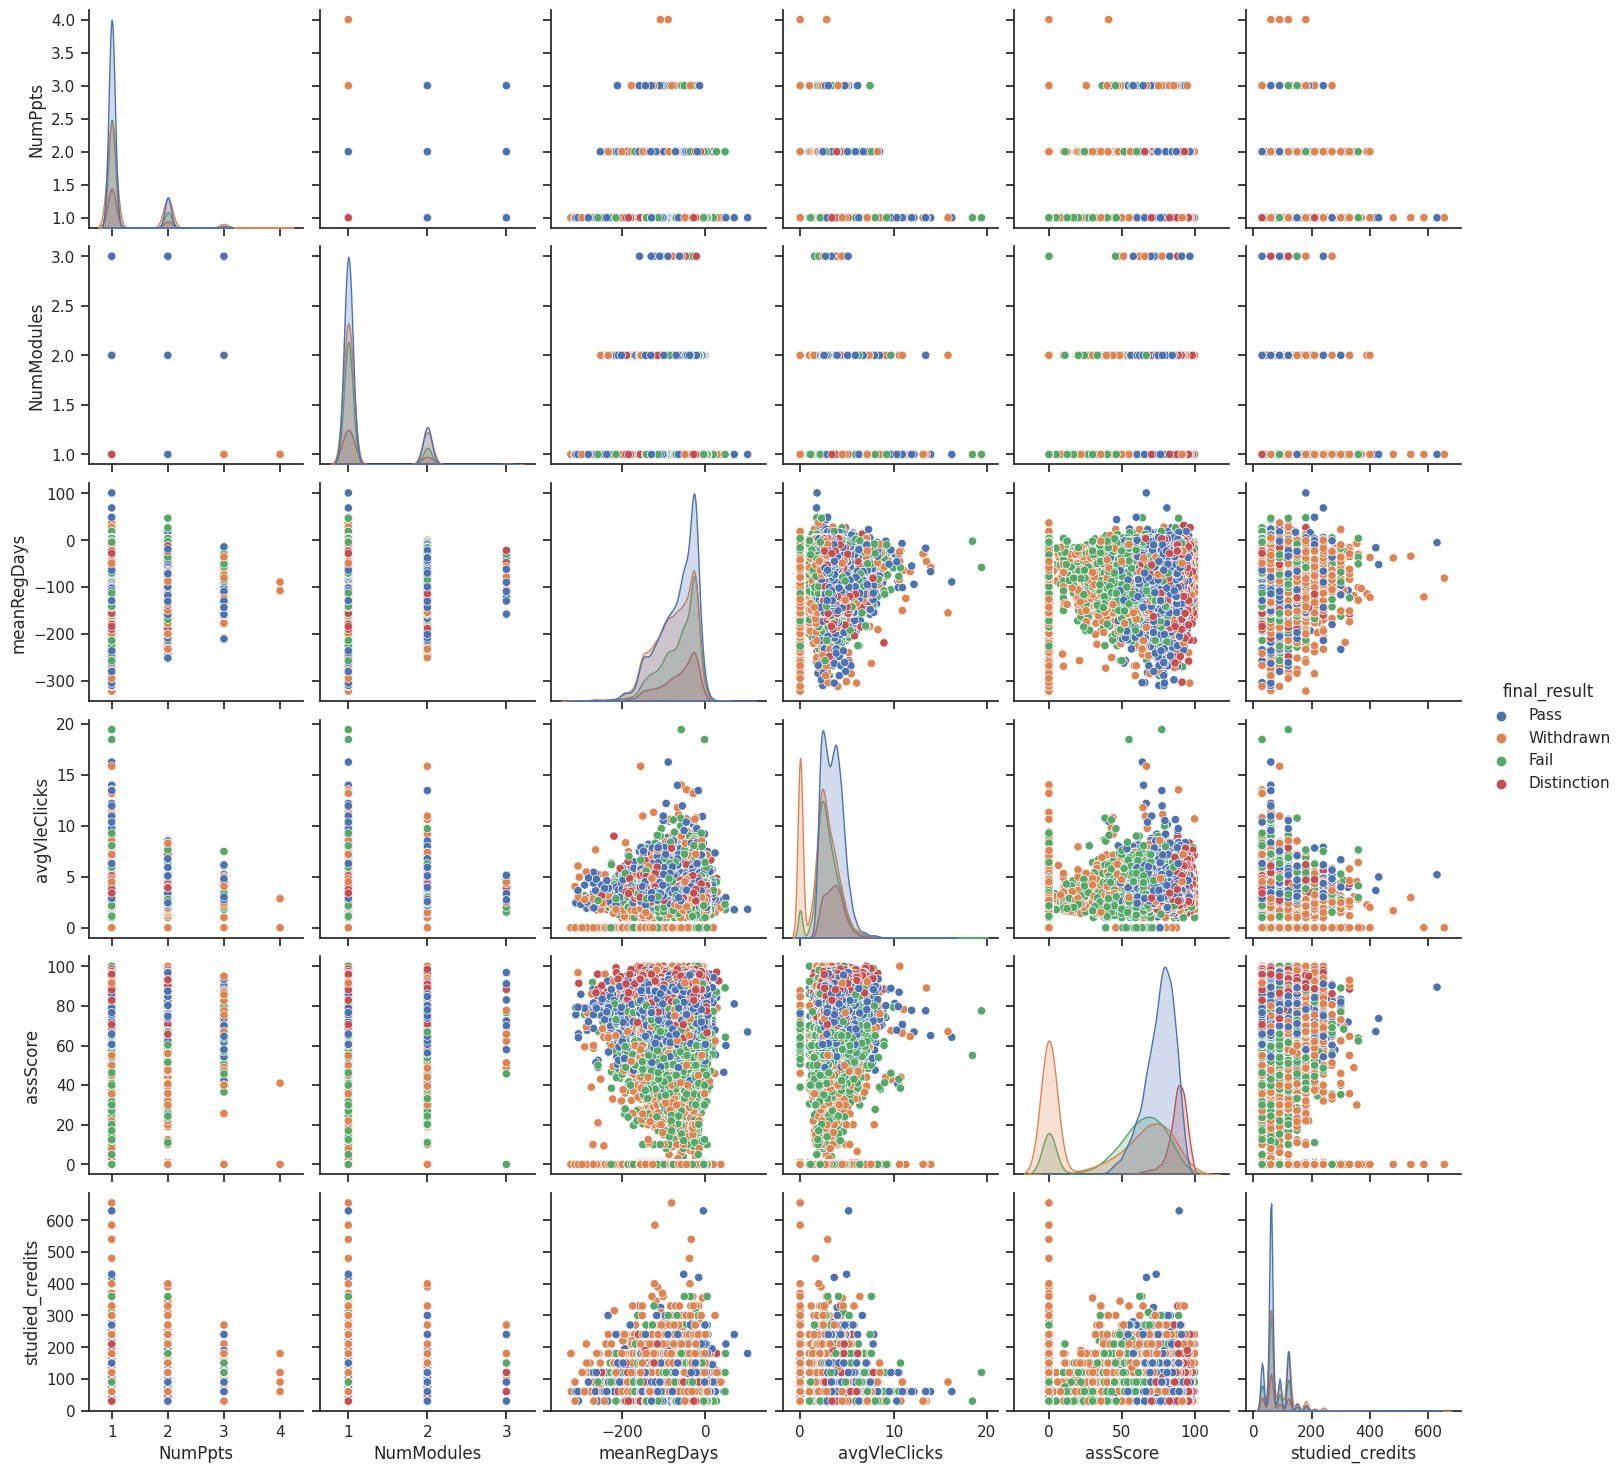

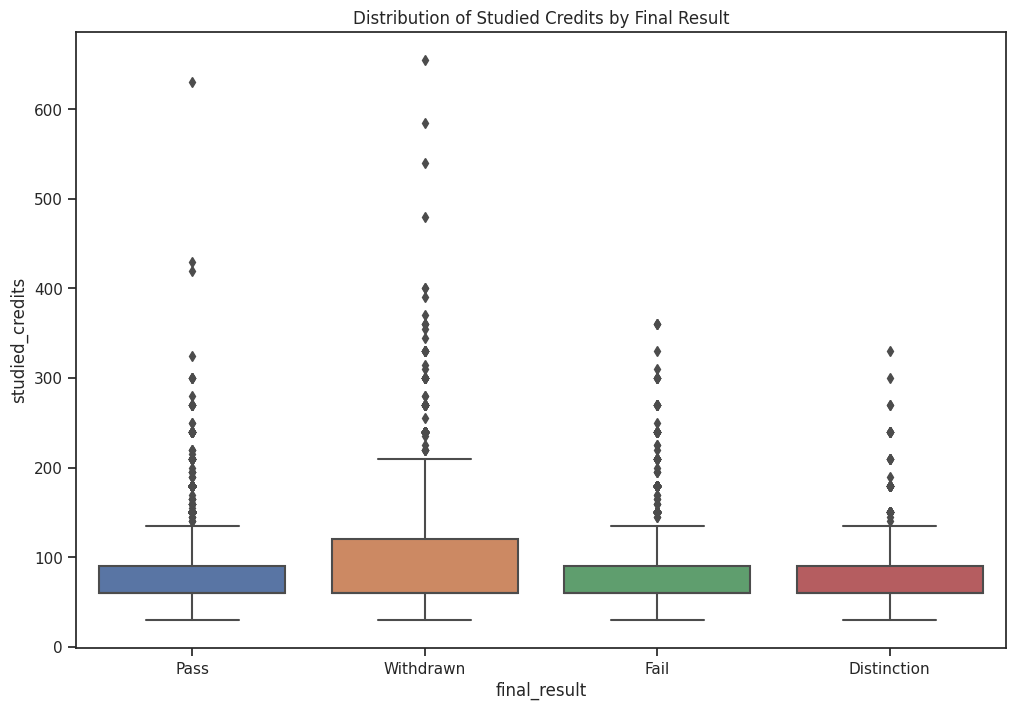

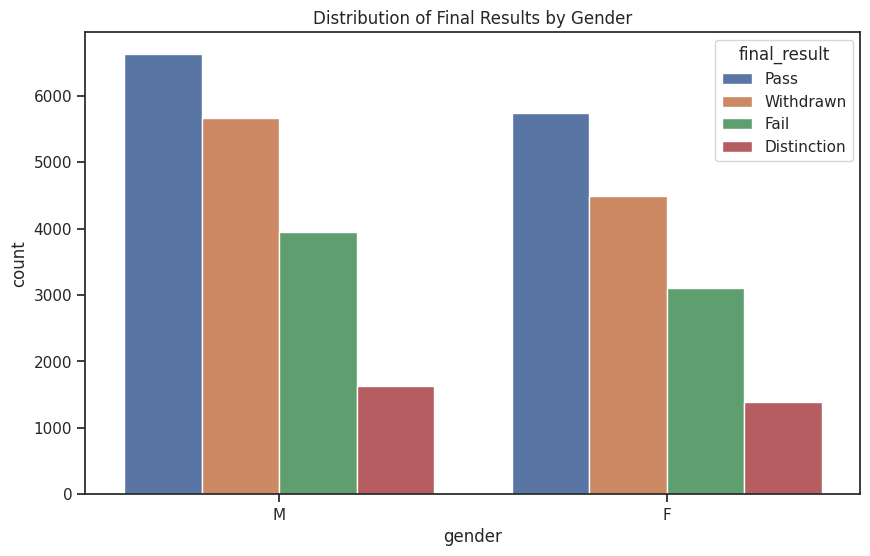

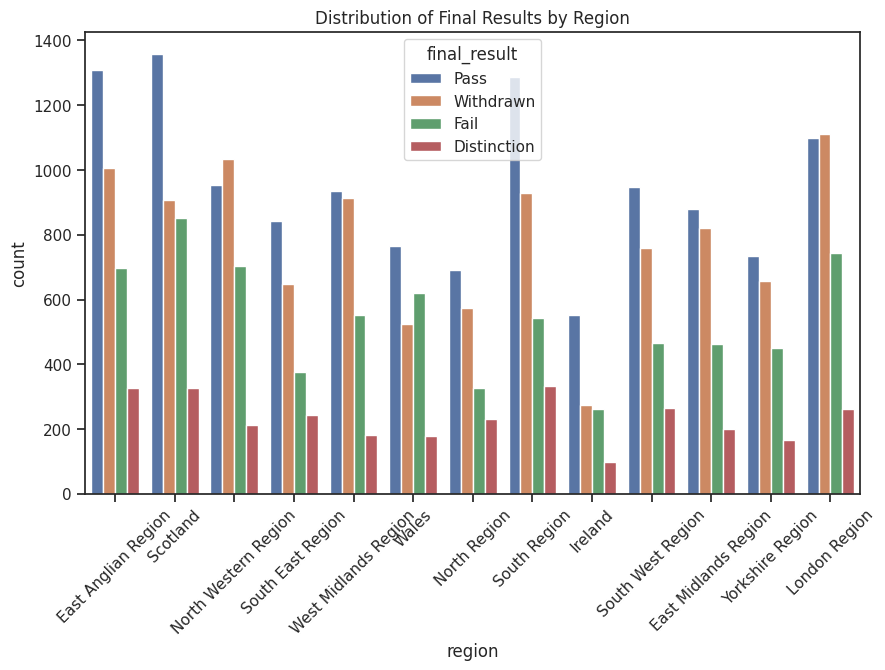

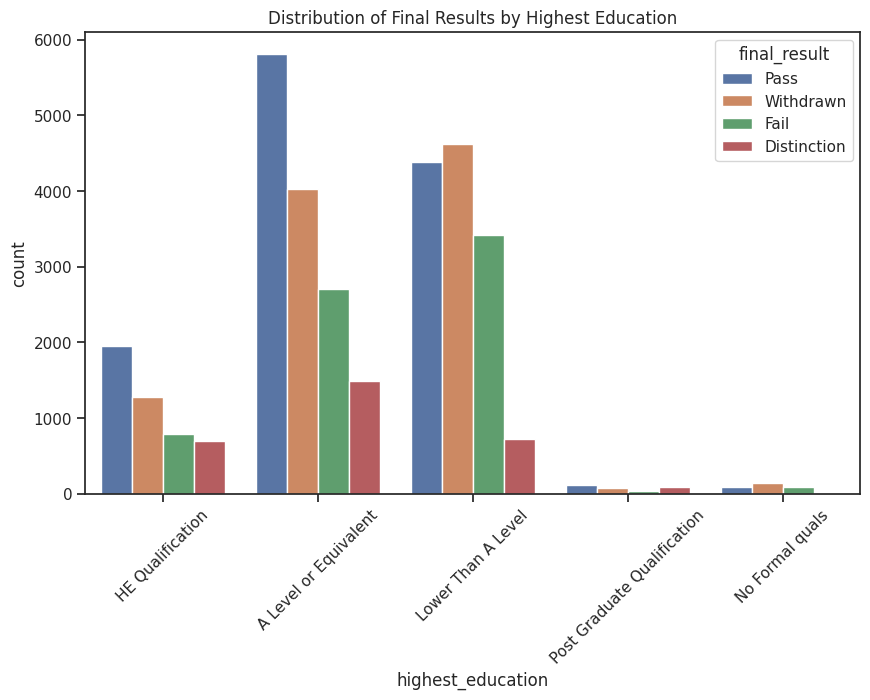

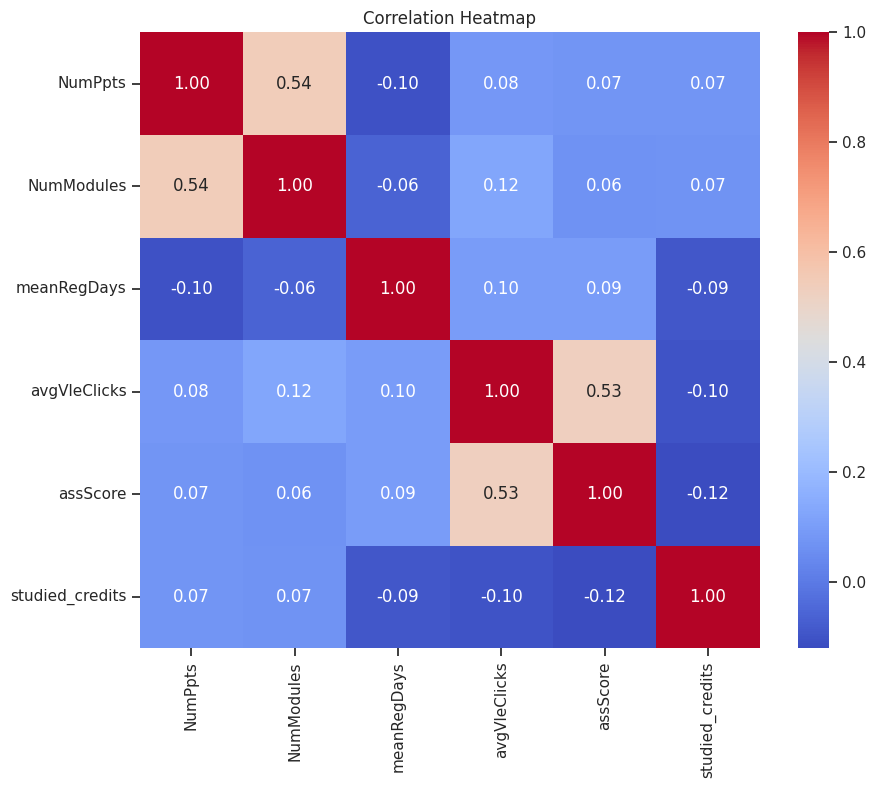

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame containing the columns mentioned
# Replace 'data' with your actual DataFrame name

# Set the style of the plots
sns.set(style="ticks")

# Pairplot to visualize pairwise relationships
sns.pairplot(data[['NumPpts', 'NumModules', 'meanRegDays', 'avgVleClicks', 'assScore', 'studied_credits', 'final_result']], hue='final_result')
plt.show()

# Boxplot to visualize distribution of numeric variables by final result
plt.figure(figsize=(12, 8))
sns.boxplot(data=data[['NumPpts', 'NumModules', 'meanRegDays', 'avgVleClicks', 'assScore', 'studied_credits', 'final_result']], x='final_result', y='studied_credits')
plt.title('Distribution of Studied Credits by Final Result')
plt.show()

# Countplot to visualize distribution of categorical variables
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='gender', hue='final_result')
plt.title('Distribution of Final Results by Gender')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='region', hue='final_result')
plt.title('Distribution of Final Results by Region')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='highest_education', hue='final_result')
plt.title('Distribution of Final Results by Highest Education')
plt.xticks(rotation=45)
plt.show()

# Correlation heatmap to visualize correlations between numeric variables
plt.figure(figsize=(10, 8))
sns.heatmap(data[['NumPpts', 'NumModules', 'meanRegDays', 'avgVleClicks', 'assScore', 'studied_credits']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [10]:
ids = data['id_student']
data = data.drop(['id_student'], axis = 1)
data['final_result'].value_counts()

final_result
Pass           12361
Withdrawn      10156
Fail            7052
Distinction     3024
Name: count, dtype: int64

In [11]:
data = data[data['final_result'] != 'Withdrawn']

In [12]:
data['final_result'] = np.where(data['final_result'] == 'Distinction', 'Pass', data['final_result'])

In [13]:
data['final_result'].value_counts()

final_result
Pass    15385
Fail     7052
Name: count, dtype: int64

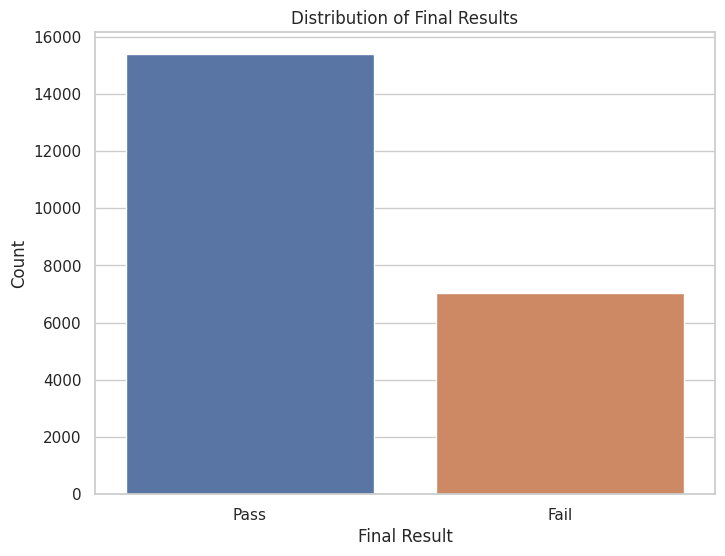

In [14]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='final_result')
plt.title('Distribution of Final Results')
plt.xlabel('Final Result')
plt.ylabel('Count')
plt.show()

In [15]:
from sklearn.model_selection import train_test_split

y = data['final_result']
X = data.drop(['final_result'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [16]:
from sklearn import preprocessing

categorical = ['gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        X_train[feature] = le.fit_transform(X_train[feature])
        X_test[feature] = le.transform(X_test[feature])
        
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)        

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

In [17]:
xgb = xg.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1)
y_pred = xgb.fit(X_train, y_train).predict(X_test)
print('XGBoost Classification accuracy score with all the features: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

XGBoost Classification accuracy score with all the features: 0.8082


In [18]:
clf_3=xg.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1)
rfecv=RFECV(estimator=clf_3,step=1,cv=5,scoring='accuracy',n_jobs=-1).fit(X_train,y_train)

In [19]:
print('Optimal features =',rfecv.n_features_)
print(' Best features =',X_train.columns[rfecv.support_])

Optimal features = 11
 Best features = Index(['NumPpts', 'NumModules', 'avgVleClicks', 'assScore', 'gender',
       'highest_education', 'imd_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'courseLength'],
      dtype='object')


In [20]:
print('XGBoost Classification accuracy score with the best features: {0:0.4f}'. format(accuracy_score(y_test, rfecv.predict(X_test))))

XGBoost Classification accuracy score with the best features: 0.8030
